In [1]:
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
#for image transform
import cv2

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200


from model_loader_CP2 import *
from CP_helper import *
from Unet import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

%load_ext autoreload
%autoreload 2
%load_ext autotime

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

time: 2.13 ms


In [3]:
torch.cuda.is_available()

True

time: 94.1 ms


In [4]:
conT = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding = 1, 
                          output_padding=1).cuda()

time: 1.04 s


In [5]:
testT = torch.randn(1, 512, 28, 28).cuda()

time: 4.12 ms


In [6]:
testT.shape

torch.Size([1, 512, 28, 28])

time: 1.75 ms


In [7]:
testTT = conT(testT)

time: 127 ms


In [8]:
testTT.shape

torch.Size([1, 256, 56, 56])

time: 1.58 ms


In [9]:
image_folder = 'data'
annotation_csv = 'data/annotation.csv'

time: 553 µs


In [10]:
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

time: 653 µs


In [11]:
#get sample
transform = torchvision.transforms.ToTensor()

unlabeled_trainset = UnlabeledDataset(image_folder=image_folder,scene_index=unlabeled_scene_index, first_dim='sample', transform=transform)
trainloader = torch.utils.data.DataLoader(unlabeled_trainset, batch_size=3, shuffle=True, num_workers=2)

time: 1.04 ms


In [12]:
# [batch_size, 6(images per sample), 3, H, W]
sample = iter(trainloader).next()
print(sample.shape)

torch.Size([3, 6, 3, 256, 306])
time: 182 ms


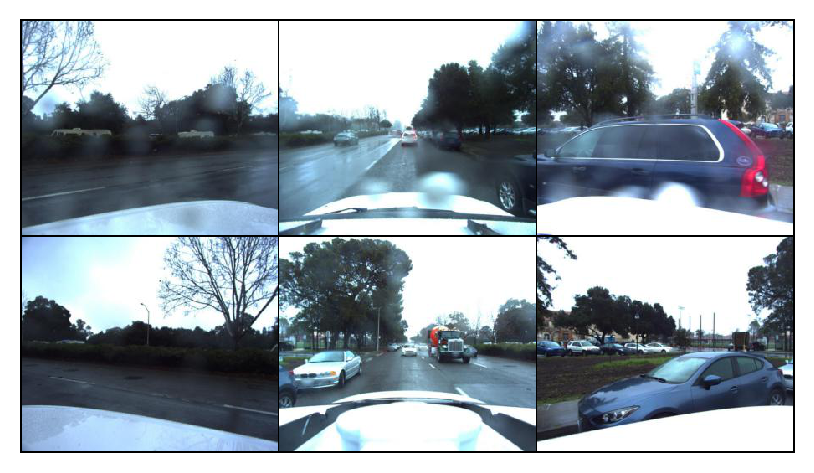

time: 319 ms


In [13]:
#The 6 images orgenized in the following order:
# 0 CAM_FRONT_LEFT, 1 CAM_FRONT, 2 CAM_FRONT_RIGHT, 3 CAM_BACK_LEFT, 4 CAM_BACK, 5 CAM_BACK_RIGHT
plt.imshow(torchvision.utils.make_grid(sample[2], nrow=3).numpy().transpose(1, 2, 0)) #need the transpose
plt.axis('off');

In [14]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
LB_trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

time: 102 ms


In [15]:
sample, target, road_image, extra = iter(LB_trainloader).next()
print(torch.stack(sample).shape)

torch.Size([2, 6, 3, 256, 306])
time: 252 ms


In [16]:
toImg = transforms.ToPILImage()

time: 601 µs


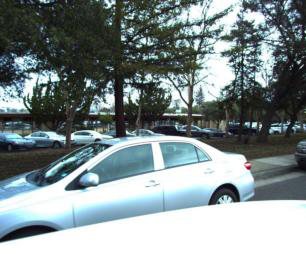

time: 25.6 ms


In [17]:

toImg(sample[0][5])

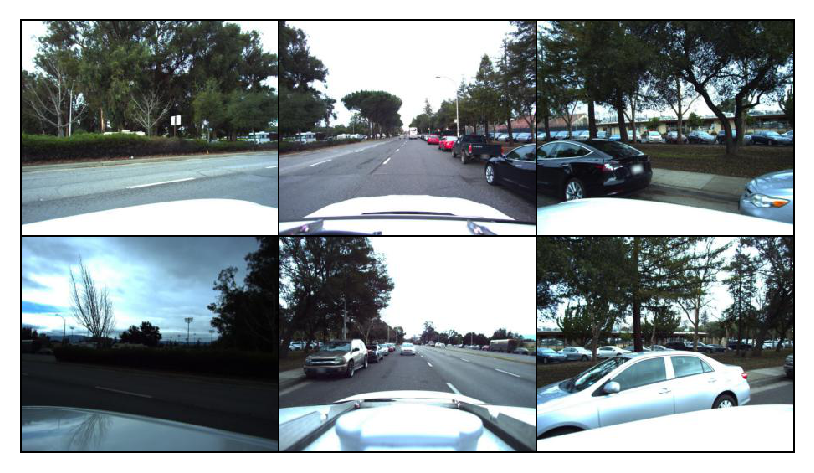

time: 292 ms


In [18]:
plt.imshow(torchvision.utils.make_grid(sample[0], nrow=3).numpy().transpose(1, 2, 0)) #need the transpose
plt.axis('off');

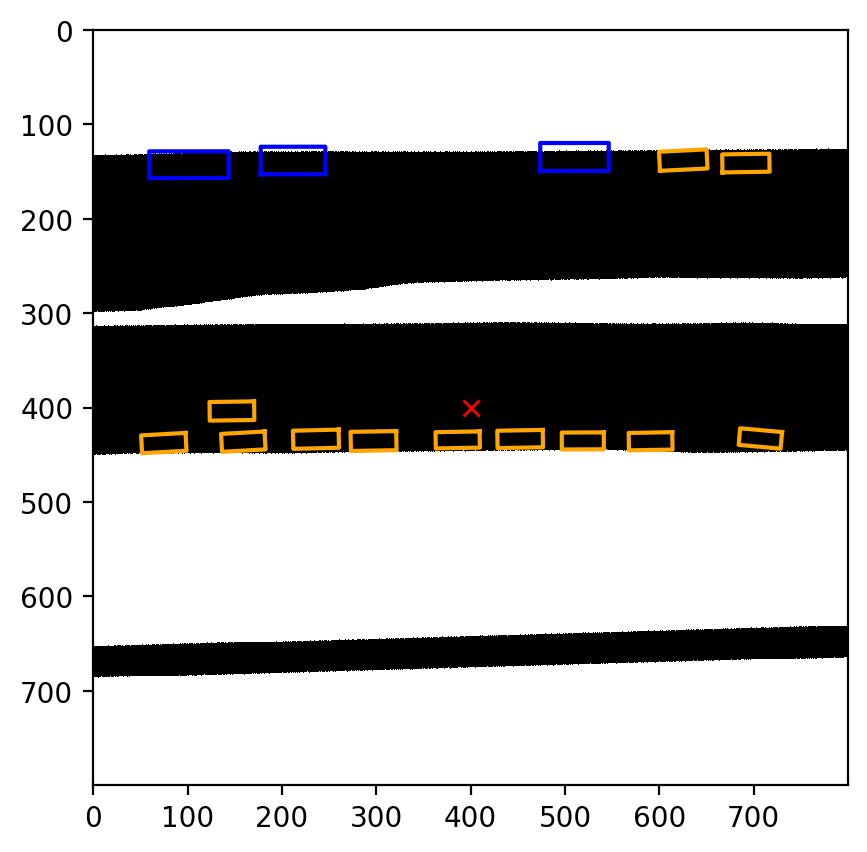

time: 246 ms


In [19]:
## ROAD IMAGE ##
# The road map layout is encoded into a binary array of size [800, 800] per sample 
# Each pixel is 0.1 meter in physiscal space, so 800 * 800 is 80m * 80m centered at the ego car
# The ego car is located in the center of the map (400, 400) and it is always facing the left

fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image[0], cmap ='binary');

# The ego car position
ax.plot(400, 400, 'x', color="red")

for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])    

In [20]:
road_image[0].size()

torch.Size([800, 800])

time: 1.6 ms


In [21]:
sample_ = ModelLoader.get_binary_road_map(sample)

T1 shape torch.Size([256, 918])
comb1 shape torch.Size([512, 918])
T1 shape torch.Size([256, 918])
comb1 shape torch.Size([512, 918])
time: 51.7 ms


In [22]:
sample_[0].size()

torch.Size([880, 880])

time: 1.56 ms


In [23]:
#min max is between 0 and 1
print(sample_[0].min())
print(sample_[1].max())

tensor(0.0039)
tensor(1.)
time: 3.78 ms


In [24]:
import torchvision.models as models
resnet18_pre = models.resnet18(pretrained=True)
resnet18_raw = models.resnet18(pretrained=False)

time: 346 ms


In [25]:
#create a normalize tranform 
res_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

time: 704 µs


In [26]:
#resnet requires all sizes to be 224 by 224
res_transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor()])

time: 706 µs


In [27]:
comb_img = ModelLoader.sew_images(sample[0])

T1 shape torch.Size([256, 918])
comb1 shape torch.Size([512, 918])
time: 17.7 ms


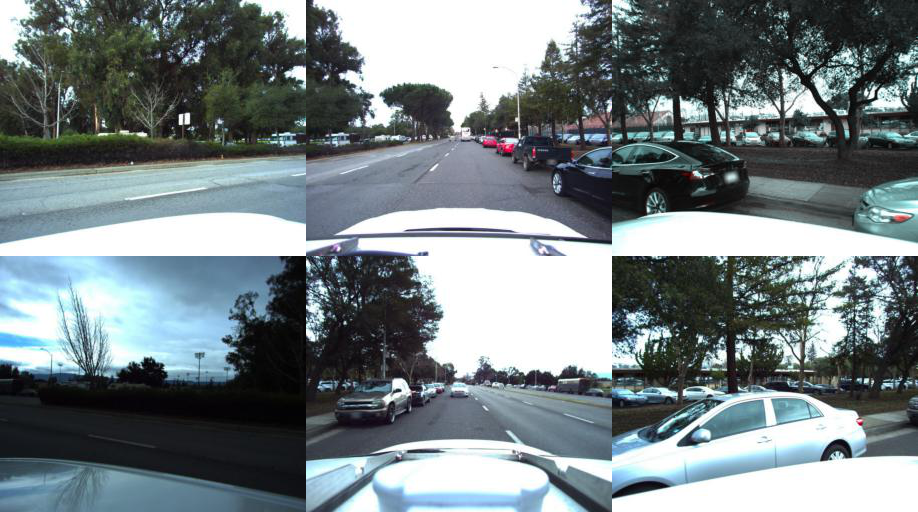

time: 102 ms


In [28]:
comb_img

In [29]:
res_comb_img = res_transform(comb_img)

time: 4.09 ms


In [30]:
res_comb_img.shape

torch.Size([3, 224, 224])

time: 1.49 ms


In [31]:
num_ftrs = resnet18_pre.fc.in_features
resnet18_pre.fc = Identity() #first set it to identity

time: 676 µs


In [32]:
##resnet is only for classification

time: 411 µs


In [33]:
testUnet = UNet(1,2)
cont_bl = testUnet.contracting_block(in_channels=1, out_channels=20, kernel_size=3)

time: 57.1 ms


In [34]:
sample_[0].size()

torch.Size([880, 880])

time: 1.57 ms


In [35]:
sample_.unsqueeze(1).size()

torch.Size([2, 1, 880, 880])

time: 1.6 ms


In [36]:
#try it with one contracting block
sample_out = cont_bl(sample_.unsqueeze(1))

time: 178 ms


In [37]:
sample_out.size()

torch.Size([2, 20, 876, 876])

time: 1.56 ms


In [38]:
#afjkd;a

NameError: name 'afjkd' is not defined

time: 90 ms


In [39]:
sing_samp_unet = sample_.unsqueeze(1)
testUnet = UNet(1,2)
testUnetout = testUnet(sing_samp_unet)

pre final shape torch.Size([2, 128, 792, 792])
time: 7.37 s


In [40]:
testUnetout.shape

torch.Size([2, 2, 788, 788])

time: 1.58 ms


In [41]:
sing_samp_unet.shape

torch.Size([2, 1, 880, 880])

time: 1.65 ms


In [42]:
testUnetout.min() #the values are not between 0 and 1 but we wil fix that with losses

tensor(-0.7583, grad_fn=<MinBackward1>)

time: 4.29 ms


In [ ]:
out.shape

In [ ]:
# t4d = torch.empty(2, 256, 213, 213)
# m = nn.ConstantPad2d((-4, -5, -4, -5), 0)
# out = m(t4d)

In [45]:
#try to refit 788 by 788 to 880 by 880
in_channels = 2
out_channels = 2
kernel_size = 5
stride = 1
refit_layer = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size), #stride default = 1
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(out_channels))

time: 2.96 ms


In [46]:
refit_out = refit_layer(testUnetout)

time: 612 ms


In [47]:
refit_out.shape

torch.Size([2, 2, 800, 800])

time: 1.85 ms


In [49]:
refit_out.max()

tensor(24.4155, grad_fn=<MaxBackward1>)

time: 3.62 ms


In [ ]:
#figure out loss

